### Training a spiking neural network on a simple vision dataset

In [63]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [64]:
# Coarse network structure dictated by the Fashin MNIST dataset
nb_inputs = 28*28
nb_hidden = 100
nb_outputs = 10

time_step = 1e-3
nb_steps = 100

batch_size = 256

In [65]:
dtype = torch.float

if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [66]:
root = os.path.expanduser("./datasets/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

In [67]:
# Standardize dataset
x_train = np.array(train_dataset.data, dtype=float)
x_train = x_train.reshape(x_train.shape[0],-1)/255

x_test = np.array(test_dataset.data, dtype=float)
x_test = x_test.reshape(x_test.shape[0],-1)/255

y_train = np.array(train_dataset.targets, dtype=int)
y_test = np.array(test_dataset.targets, dtype=int)

(-0.5, 27.5, 27.5, -0.5)

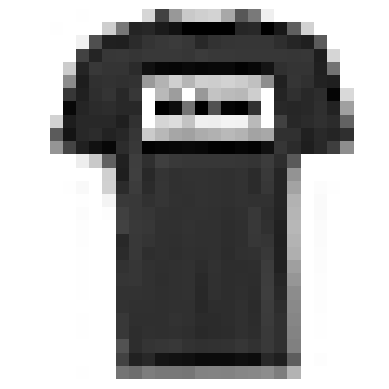

In [68]:
# plot an example
data_id = 1
plt.imshow(x_train[data_id].reshape(28, 28), cmap=plt.cm.gray_r)
plt.axis("off")

In [69]:
# Use a spike latency code to feed spikes to the neural network.
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """
    Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron
    x - the current values
    tau - the membrane time constant of the LIF neuron to be chargedd
    thr - the firing thresholdd value
    tmax - The maximum time returned
    """
    idx = x<thr
    x = np.clip(x, thr+epsilon, 1e9)
    T = tau * np.log(x/(x-thr))
    T[idx] = tmax
    return T

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True):
    """
    This generator takes datasets in analog format and generate spiking network input as sparse tensors.
    X - the data (sample x event x 2) -> the last dim holds (time, neuron) tuples
    y - the labels
    """
    labels_ = np.array(y, dtype=int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))
    
    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=int)
    unit_numbers = np.arange(nb_units)
    
    if shuffle:
        np.random.shuffle(sample_index)
        
    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]
        
        coo = [[] for i in range(3)]
        for bc, idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]
            
            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)
            
        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size, nb_steps, nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index], device=device)
        
        yield X_batch.to(device=device), y_batch.to(device=device)
        
        counter +=1
    

### Setup SNN

In [70]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha = float(np.exp(-time_step/tau_syn))
beta = float(np.exp(-time_step/tau_mem))

In [71]:
weight_scale = 7*(1.0-beta)
w1 = torch.empty((nb_inputs, nb_hidden), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [72]:
def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5):
    gs = GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i == 0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i], sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

### Surrogate Graddient

In [73]:
class SurrGradSpike(torch.autograd.Function):
    scale = 100.0
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input>0] = 1.0
        return out
    
    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
spike_fn = SurrGradSpike.apply

In [74]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size, nb_hidden), device=device, dtype=dtype)
    
    mem_rec = []
    spk_rec = []
    
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach()
        
        new_syn = alpha * syn + h1[:, t]
        new_mem = (beta*mem + syn)*(1.0-rst)
        
        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn
        
    mem_rec = torch.stack(mem_rec, dim=1)
    spk_rec = torch.stack(spk_rec, dim=1)
    
    # Readouit layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size, nb_outputs), device = device, dtype = dtype)
    out = torch.zeros((batch_size, nb_outputs), device = device, dtype = dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha * flt + h2[:, t]
        new_out = beta * out + flt
        
        flt = new_flt
        out = new_out
        
        out_rec.append(out)
        
    out_rec = torch.stack(out_rec, dim=1)
    other_recs = [mem_rec, spk_rec]
    return out_rec, other_recs

In [75]:
def train(x_data, y_data, lr=2e-3, nb_epochs=10):
    params = [w1, w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9, 0.999))
    
    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output, _ = run_snn(x_local.to_dense())
            m, _ = torch.max(output, 1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)
            
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist

In [76]:
def compute_classification_accuracy(x_data, y_data):
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output, _ = run_snn(x_local.to_dense())
        m, _ = torch.max(output, 1)
        _, am = torch.max(m, 1)
        tmp = np.mean((y_local==am).detach().cpu().numpy())
        accs.append(tmp)
    return np.mean(accs)

In [77]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=30)

Epoch 1: loss=0.98642
Epoch 2: loss=0.54228
Epoch 3: loss=0.47571
Epoch 4: loss=0.44429
Epoch 5: loss=0.42246
Epoch 6: loss=0.40471
Epoch 7: loss=0.38903
Epoch 8: loss=0.37844
Epoch 9: loss=0.36531
Epoch 10: loss=0.35739
Epoch 11: loss=0.34785
Epoch 12: loss=0.34039
Epoch 13: loss=0.33264
Epoch 14: loss=0.32798
Epoch 15: loss=0.32033
Epoch 16: loss=0.31602
Epoch 17: loss=0.31054
Epoch 18: loss=0.30369
Epoch 19: loss=0.29741
Epoch 20: loss=0.29291
Epoch 21: loss=0.29021
Epoch 22: loss=0.28577
Epoch 23: loss=0.28125
Epoch 24: loss=0.27566
Epoch 25: loss=0.27289
Epoch 26: loss=0.26688
Epoch 27: loss=0.26407
Epoch 28: loss=0.26015
Epoch 29: loss=0.25825
Epoch 30: loss=0.25230


In [80]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train, y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test, y_test)))

Training accuracy: 0.910
Test accuracy: 0.862


In [81]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=shuffle):
        return ret

In [82]:
x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn(x_batch.to_dense())
mem_rec, spk_rec = other_recordings

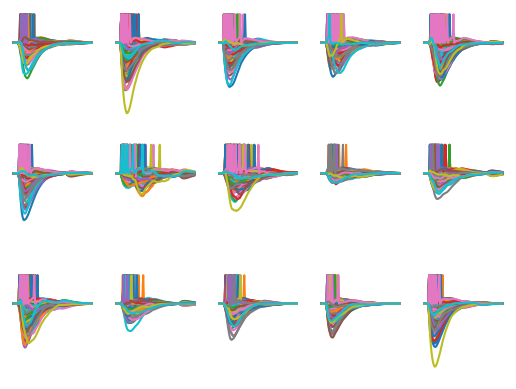

In [83]:
fig = plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

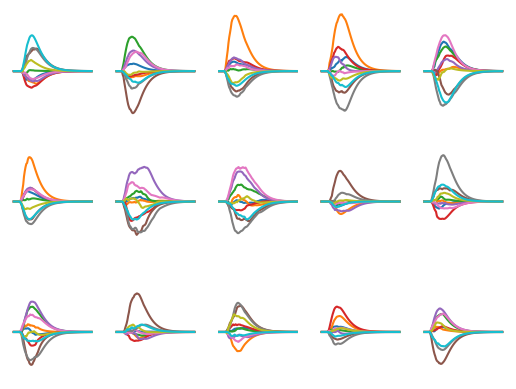

In [84]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

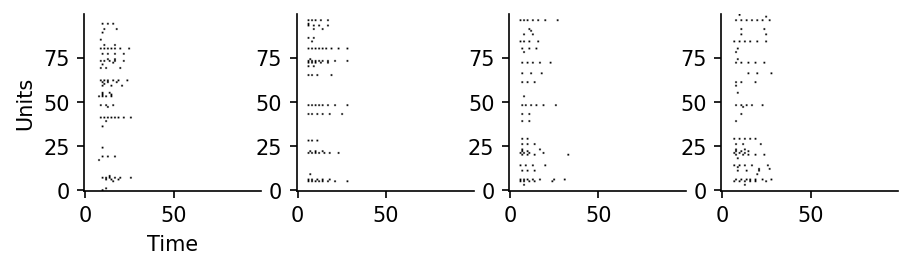

In [86]:
nb_plt = 4
gs = GridSpec(1, nb_plt)
fig  = plt.figure(figsize=(7, 3), dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T, cmap=plt.cm.gray_r, origin="lower")
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")
    sns.despine()